In [6]:
%run "../08222019_functions.ipynb"

In [2]:
###### loading phase2 metadata ######
metadata = pd.read_csv("samples.meta.txt", sep="\t")
pop_select = metadata.population.isin({'BFcol', 'BFgam', 'AOcol'}).values
pop_subset = metadata[pop_select]

In [3]:
genotypes_phase2_call = calldata_phase2['3L']["calldata/GT"]
genotypes_phase2_call

<zarr.core.Array '/3L/calldata/GT' (7897666, 1142, 2) int8 read-only>

In [4]:
pos = allel.SortedIndex(calldata_hap_phase2["3L"]["variants/POS"])
pos

0,1,2,3,4,...,7897661,7897662,7897663,7897664,7897665
9790,9791,9798,9812,9815,...,41956530,41956532,41956537,41956541,41956551


In [5]:
genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
genotypes_phase2

<GenotypeChunkedArray shape=(7897666, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=16.8G cbytes=-1 cratio=-18038269144.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [6]:
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)

In [7]:
geno_p2_subset

<GenotypeChunkedArray shape=(7897666, 245, 2) dtype=int8 chunks=(7713, 245, 2)
   nbytes=3.6G cbytes=154.1M cratio=23.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [8]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [89]:
pbs = allel.pbs(ac_subpops['BFcol'], ac_subpops['BFgam'], ac_subpops['AOcol'], 1000)

In [90]:
# compute windows with equal numbers of SNPs
windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=1000)
x = np.asarray(windows).mean(axis=1) 

In [91]:
len(x), len(pbs)

(7897, 7897)

(0, 41956551)

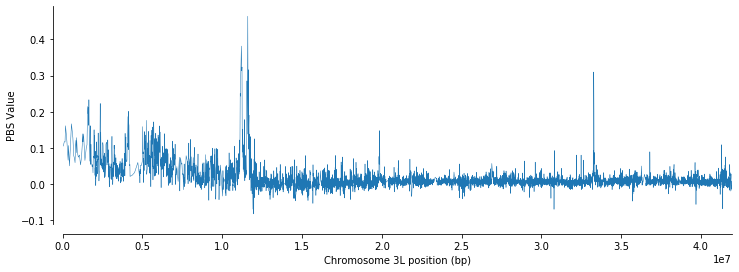

In [121]:
# Plot the test
fig, ax = pyplot.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, pbs, lw=.5)
sns.despine(ax=ax, offset=10)
ax.set_ylabel("PBS Value")
ax.set_xlabel('Chromosome 3L position (bp)')
ax.set_xlim(0, pos.max())

In [124]:
pbs_bool = pbs > 0.30

In [125]:
x[pbs_bool]

array([11203978. , 11228496. , 11243170.5, 11603484. , 11647583. ,
       33281581.5])

In [130]:
np.where(x==11603484)

(array([1014]),)

In [131]:
x[1014]

11603484.0

Found these genes on vectorbase:
   - Gene: TEP3 AGAP010816 , region 11,215,193-11'220'113 (11,203,978 11,228,496)
   - Gene: AGAP010817, region 11,241,256-11,260,276 (11,243,170)
   - Gene: TEP9 AGAP010830, region 11,595,490-11,600,414 (11,603,484)
   - No genes (11,647,583)
   - Gene: CLIPA2 AGAP011790, region 33,279,935-33,281,894 (33,281,581)

----------------------------------------------

## Create Function for pbs

In [139]:
def pbs_plot(chrom, a, b, c, windows_size):

    ###### loading phase2 metadata ######
    metadata = pd.read_csv("samples.meta.txt", sep="\t")
    pop_select = metadata.population.isin({a, b, c}).values
    pop_subset = metadata[pop_select]
    
    ###### loading phase2 genome and subset ######
    genotypes_phase2_call = calldata_phase2[chrom]["calldata/GT"]
    genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
    pos = allel.SortedIndex(calldata_phase2[chrom]["variants/POS"])
    geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)

    
    ###### perform allele count to my subpopulations ######
    grp = pop_subset.groupby("population")
    grp_indices = grp.indices
    ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)
    
    ##### perform pbs #####
    pbs = allel.pbs(ac_subpops[a], ac_subpops[b], ac_subpops[c], windows_size)

    
    ###### compute windows with equal numbers of SNPs ######
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=windows_size)
    x = np.asarray(windows).mean(axis=1)
    pbs_bool = pbs > 0.10
    pbs_spikes = x[pbs_bool]
    print ('Spikes PBS>10:',pbs_spikes)
    ###### Plot the test ######
    fig, ax = pyplot.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, pbs, lw=.5)
    ax.set_ylabel("PBS Value")
    ax.set_xlabel('Chromosome %s position (bp)' %chrom)
    ax.set_xlim(0, pos.max())
    ax.set_title(('PBS between %s, %s, %s populations on chromosome %s') % (a,b,c,chrom))

[  336426.5  1333969.5  1649788.   2390797.   4093133.   5584776.
 11101452.5 11202023.5 11596058.5 11684164.5 33273627. ]


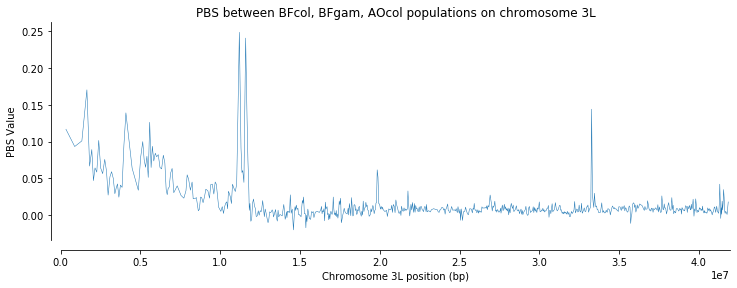

In [137]:
pbs_plot('3L', 'BFcol', 'BFgam', 'AOcol', 10000)

Spikes PBS>10: [ 1239563.   9789680.   9796047.5  9802210.5 10180816.  10185682.5
 10246778.5 10271151.5 10278282.  10282291.5 10382963.  10402685.5
 10408340.  10416735.5 10424888.  10446200.  10455934.  11472496.
 11922033.  11929259.  11974882.5 12000845.5 12007913.5 12032670.5
 12088819.  13009808.  14436244.  14543423.  14558213.5 14568145.
 14574869.  15293416.5 15296431.5 15365343.  30793705.5 38062801.5
 41824776.5 41834324.5 41848222.  41862559.5 41874295.  41883890.
 41893138.  41901642.5 41910607.  41920463.5 41944430.5]


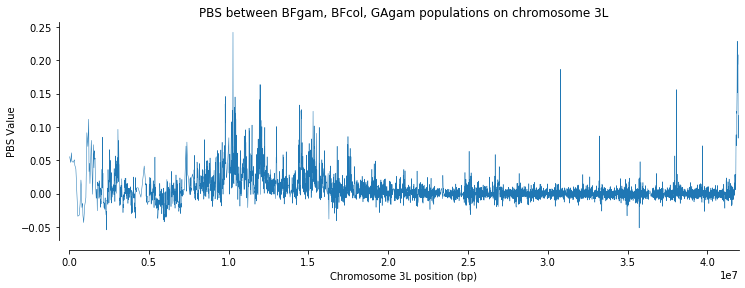

In [140]:
pbs_plot('3L', 'BFgam', 'BFcol', 'GAgam', 1000)

-------------------------------------

## Using <i>christiy</i> as outgroup

In [9]:
calldata_chri= h5py.File('chri_ac_phase2_map.h5', mode='r')

In [10]:
len(calldata_chri['3L']), len(ac_subpops['BFgam'])

(6780124, 7897666)

In [11]:
pos_phase1 = allel.SortedIndex(calldata_phase1['3L']["variants/POS"][:])
pos_phase2 = allel.SortedIndex(calldata_phase2['3L']["variants/POS"][:])
loc1, loc2 = pos_phase2.locate_intersection(pos_phase1)
pos_p2_sel = pos_phase2.compress(loc1)

In [12]:
geno_p2_subset = genotypes_phase2.subset(sel0=loc1, sel1=pop_select)

In [13]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [14]:
len(calldata_chri['3L']), len(ac_subpops['BFgam'])

(6780124, 6780124)

In [15]:
calldata_chri['3L']

<HDF5 dataset "3L": shape (6780124, 2), type "<i4">

In [16]:
pbs = allel.pbs(ac_subpops['BFcol'], ac_subpops['BFgam'], calldata_chri['3L'], 1000)

/opt/conda/lib/python3.6/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum


In [17]:
# compute windows with equal numbers of SNPs
windows = allel.moving_statistic(pos_p2_sel, statistic=lambda v: [v[0], v[-1]], size=1000)
x = np.asarray(windows).mean(axis=1) 

In [18]:
len(x), len(pbs)

(6780, 6780)

(0, 41956551)

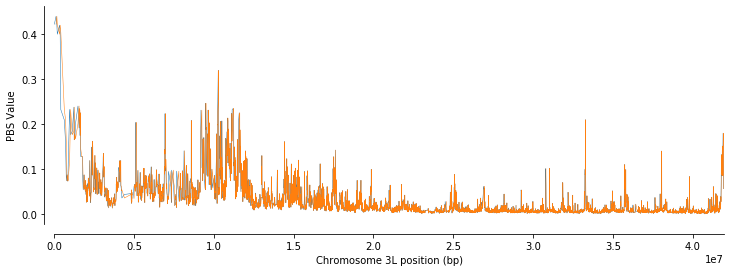

In [20]:
# Plot the test
fig, ax = pyplot.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(windows, pbs, lw=.5)
ax.set_ylabel("PBS Value")
ax.set_xlabel('Chromosome 3L position (bp)')
ax.set_xlim(0, pos_p2_sel.max())